In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import signal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, GridSearchCV  , StratifiedGroupKFold, cross_validate
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier

from random import sample, shuffle
from sklearn.linear_model import SGDClassifier
from sklearn.base import clone
from copy import deepcopy

import matplotlib.pyplot as plt 
import seaborn as sns

In [5]:
#dataset_path_root = "/home/bruno/Academico/Doctorado/Neuro_Fairness/Shu_Dataset/004_Dataset_6_Random_Feature_Extraction/"
dataset_path_root = "/home/bzorzet/Academico/Neuro_Fairness/Shu_Dataset/002_Dataset_Traditional_Feature_Extraction/"

participants=["sub-001","sub-002","sub-003","sub-004","sub-005",
              "sub-006","sub-007","sub-008","sub-009","sub-010",
              "sub-011","sub-012","sub-013","sub-014","sub-015",
              "sub-016","sub-017","sub-018","sub-019","sub-020",
              "sub-021","sub-022","sub-023","sub-024","sub-025"]
sessions = ["ses-01","ses-02","ses-03","ses-04","ses-05"]

In [6]:
dataset={}
for participant in participants:
    dataset[participant]={}
    data_path=participant+"_task_motorimagery_eeg_preprocessing_trad_feature.mat"
    data=sio.loadmat(dataset_path_root + data_path)
    for session in sessions:
        dataset[participant][session +'_data_band_power']=data[session +'_data_band_power']
        dataset[participant][session +'_labels_trials']=data[session +'_labels_trials']
    dataset[participant]['sfreq']=np.squeeze(data['sfreq'])
    dataset[participant]['age']=np.squeeze(data['age'])
    dataset[participant]['gender']=data['gender'][0]
    dataset[participant]['group_medidator']=data['group_medidator'][0]
    dataset[participant]['id_participant']=data['id_participant'][0]

In [7]:
index_female = []
index_male = []
for participant in participants:
    if dataset[participant]['gender'] == 'M':
        index_male.append(participant)
    elif dataset[participant]['gender'] == 'F':
        index_female.append(participant)
print(f"Participantes hombres: {index_male}")
print(f"Participantes mujeres: {index_female}")

Participantes hombres: ['sub-001', 'sub-002', 'sub-008', 'sub-012', 'sub-013', 'sub-015', 'sub-017', 'sub-018', 'sub-019', 'sub-021', 'sub-022', 'sub-023', 'sub-025']
Participantes mujeres: ['sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-009', 'sub-010', 'sub-011', 'sub-014', 'sub-016', 'sub-020', 'sub-024']


In [8]:
for participant in participants:
    data_ = np.concatenate((dataset[participant]['ses-01_data_band_power'],
                            dataset[participant]['ses-02_data_band_power'],
                            dataset[participant]['ses-03_data_band_power'],
                            dataset[participant]['ses-04_data_band_power'],
                            dataset[participant]['ses-05_data_band_power']),axis=0)
    
    dataset[participant]['data_band_power'] = data_
    dataset[participant]['data_gender'] =  np.array(list(dataset[participant]['gender']) * data_.shape[0])
    dataset[participant]['group_participant'] =  np.array(list([participant]) * data_.shape[0])

In [31]:
n_features = 6 #RANDOM SAMPLE QUANTITY
N_sr = 100 #RANDOM SAMPLING QUANTITY

N_folds = 20
n_test_participant = 2
n_val_participant = 2 
n_ign_participant = 1
max_iter = 200
patience = 50 

info_exp = {}
for it_sr in range(N_sr):
    info_folds = {}
    info_clfs = {}

    #Random sample per subject
    for participant in participants:
        X = dataset[participant]['data_band_power']
        n_0 = X.shape[0]
        n_1 = X.shape[1]
        n_2 = X.shape[2]
        X =X.reshape((n_0,n_1*n_2))
        X_random = np.zeros((n_0,n_features))
        for it0 in range(n_0):
            X_random[it0,:]=sample(X[it0,:].tolist(), n_features)
        dataset[participant]['data_random'] = np.array(X_random)

    #Train Model    
    for it in range(N_folds):
        dic_aux = {}
        
        X_train = None
        X_val = None
        X_test = None 
        
        X_train_ = None
        X_val_ = None
        X_test_ = None
        
        idx_male = index_male.copy()
        idx_female = index_female.copy()
        
        # TEST PARTICIPANTS:
        idx_male_test = sample(idx_male, n_test_participant)
        idx_female_test = sample(idx_female, n_test_participant)
        for it_ in range(n_test_participant):
            idx_male.remove(idx_male_test[it_])
            idx_female.remove(idx_female_test[it_])
        idx_test = idx_male_test + idx_female_test
        dic_aux['reg_idx_test'] = idx_test   
        
        # VALIDATION PARTICIPANTS:
        idx_male_val = sample(idx_male, n_val_participant)
        idx_female_val = sample(idx_female, n_val_participant)
        for it_ in range(n_val_participant):
            idx_male.remove(idx_male_val[it_])
            idx_female.remove(idx_female_val[it_])
        idx_val = idx_male_val + idx_female_val
        dic_aux['reg_idx_val'] = idx_val  
        
        # TRAIN PARTICIPANTS:
        idx_male_ignore = sample(idx_male, n_ign_participant)
        for it_ in range(n_ign_participant):
            idx_male.remove(idx_male_ignore[it_])
        idx_male_train = idx_male.copy()
        idx_female_train = idx_female.copy()
        idx_train = idx_male_train + idx_female_train
        dic_aux['reg_idx_train'] = idx_train    
            
        
        # CONCATENAMOS EL CONJUNTO DE DATOS
        # TEST
        X_test = np.zeros((1,n_features))
        Y_test = np.zeros(1)
        for participant in idx_test:
            X_test = np.concatenate((X_test, dataset[participant]['data_random']),axis=0)
            Y_test = np.concatenate((Y_test, dataset[participant]['data_gender']),axis=0)
        X_test = X_test[1:,:]
        Y_test = Y_test[1:]
        dic_aux['n_trials_test'] = {'male':np.sum(Y_test == 'M'),'female':np.sum(Y_test == 'F')}
        dic_aux['proportion_trials_test'] = {'male':np.sum(Y_test == 'M')/(np.sum(Y_test == 'M')+np.sum(Y_test == 'F')),
                                        'female':np.sum(Y_test == 'F')/(np.sum(Y_test == 'M')+np.sum(Y_test == 'F'))}
        # VALIDATION
        X_val = np.zeros((1,n_features))
        Y_val = np.zeros(1)
        for participant in idx_val:
            X_val = np.concatenate((X_val, dataset[participant]['data_random']),axis=0)
            Y_val = np.concatenate((Y_val, dataset[participant]['data_gender']),axis=0)
        X_val = X_val[1:,:]
        Y_val = Y_val[1:]
        dic_aux['n_trials_val'] = {'male':np.sum(Y_val == 'M'),'female':np.sum(Y_val == 'F')}
        dic_aux['proportion_trials_val'] = {'male':np.sum(Y_val == 'M')/(np.sum(Y_val == 'M')+np.sum(Y_val == 'F')),
                                        'female':np.sum(Y_val == 'F')/(np.sum(Y_val == 'M')+np.sum(Y_val == 'F'))}
            
        # TRAIN
        X_train = np.zeros((1,n_features))
        Y_train = np.zeros(1)
        for participant in idx_train:
            X_train = np.concatenate((X_train, dataset[participant]['data_random']),axis=0)
            Y_train = np.concatenate((Y_train, dataset[participant]['data_gender']),axis=0)
        X_train = X_train[1:,:]
        Y_train = Y_train[1:]
        dic_aux['n_trials_train'] = {'male':np.sum(Y_train == 'M'),'female':np.sum(Y_train == 'F')}
        dic_aux['proportion_trials_train'] = {'male':np.sum(Y_train == 'M')/(np.sum(Y_train == 'M')+np.sum(Y_train == 'F')),
                                        'female':np.sum(Y_train == 'F')/(np.sum(Y_train == 'M')+np.sum(Y_train == 'F'))}   
        
        info_folds[f'fold_{it}']=dic_aux

        
        dic_aux={}
         #-----------------------CLASSIFIER 1 -----------------------------#
        acc_train = None
        acc_val = None
        acc_test = None
        
        tol = 1e-4
        scaler = StandardScaler()
        clf = LinearDiscriminantAnalysis(tol=tol)
        
        X_train_ = scaler.fit_transform(X_train, Y_train)
        X_val_ = scaler.transform(X_val)
        X_test_ = scaler.transform(X_test)
        
        
        clf.fit(X_train_, Y_train)
        acc_train = clf.score(X_train_ , Y_train)
        acc_val = clf.score(X_val_ , Y_val)
        acc_test = clf.score(X_test_, Y_test)
        
        dic_aux['clf_1']={'estimator': clf, 'acc_train': acc_train, 'acc_val' : acc_val, 'acc_test' : acc_test}



        # #-----------------------CLASSIFIER 2 -----------------------------#
        # acc_train = None
        # acc_val = None
        # acc_test = None
        
        # tol = 1e-4
        # scaler = StandardScaler()
        # clf = svm.SVC(C=1.0, kernel='linear', tol=tol)
        
        # X_train_ = scaler.fit_transform(X_train, Y_train)
        # X_val_ = scaler.transform(X_val)
        # X_test_ = scaler.transform(X_test)
        
        
        # clf.fit(X_train_, Y_train)
        # acc_train = clf.score(X_train_ , Y_train)
        # acc_val = clf.score(X_val_ , Y_val)
        # acc_test = clf.score(X_test_, Y_test)
        
        # dic_aux['clf_2']={'estimator': clf, 'acc_train': acc_train, 'acc_val' : acc_val, 'acc_test' : acc_test}
        
        # #-----------------------CLASSIFIER 3 -----------------------------#
        # acc_train = None
        # acc_val = None
        # acc_test = None
        
        # tol = 1e-4
        # scaler = StandardScaler()
        # clf = svm.SVC(C=1.0, kernel='rbf', tol=tol)
        
        # X_train_ = scaler.fit_transform(X_train, Y_train)
        # X_val_ = scaler.transform(X_val)
        # X_test_ = scaler.transform(X_test)
        
        
        # clf.fit(X_train_, Y_train)
        # acc_train = clf.score(X_train_ , Y_train)
        # acc_val = clf.score(X_val_ , Y_val)
        # acc_test = clf.score(X_test_, Y_test)
        
        # dic_aux['clf_3']={'estimator': clf, 'acc_train': acc_train, 'acc_val' : acc_val, 'acc_test' : acc_test}
        
        
        # #-----------------------CLASSIFIER 4 -----------------------------#
        # acc_train_scores = []
        # acc_val_scores = []
        # acc_train = 0
        # acc_val = 0
        # acc_test = 0
        
        # # Counter for patience
        # it_patience = 0
        
        # # Best classifier in early stopping
        # best_clf = None
        # it_stop = 0 
        
        # scaler = StandardScaler()
        # clf = MLPClassifier(hidden_layer_sizes=(10,8,5), activation='relu', solver='adam', alpha=0.0001,
        #                     learning_rate='constant', learning_rate_init=0.01,max_iter=max_iter)
        # classes = np.unique(Y_train)

        # for it_ in range(max_iter):
        #     # Scaler fit/transform
        #     scaler.partial_fit(X_train, Y_train)
        #     X_train_ = scaler.transform(X_train)
        #     X_val_ = scaler.transform(X_val)
            
        #     # Classifier fit / evaluate
        #     clf.partial_fit(X_train_,Y_train,classes=classes)
        #     acc_train_scores.append(clf.score(X_train_,Y_train))
        #     acc_val_scores.append(clf.score(X_val_,Y_val))
            
        #     if acc_val_scores[-1] >= acc_val:
        #         acc_val = acc_val_scores[-1]
        #         best_clf = deepcopy(clf)
        #         it_stop = it_
        #         it_patience = 0
        #     else: 
        #         it_patience += 1
            
        #     if it_patience >= patience:
        #         break
            
        # X_test_ = scaler.transform(X_test)    
        # acc_test = best_clf.score(X_test_,Y_test)
        # acc_train = acc_train_scores[it_stop] 
        
        # dic_aux['clf_4']={'estimator': clf, 'acc_train': acc_train, 'acc_val' : acc_val, 'acc_test' : acc_test,
        #                 'acc_train_scores': acc_train_scores, 'acc_val_scores': acc_val_scores, 'it_stop':it_stop}
        
        # #-----------------------CLASSIFIER 5 -----------------------------#
        # acc_train_scores = []
        # acc_val_scores = []
        # acc_train = 0
        # acc_val = 0
        # acc_test = 0
        
        # # Counter for patience
        # it_patience = 0
        
        # # Best classifier in early stopping
        # best_clf = None
        # it_stop = 0 
        
        # scaler = StandardScaler()
        # clf = MLPClassifier(hidden_layer_sizes=(10,8,3), activation='relu', solver='adam', alpha=0.0001,
        #                     learning_rate='constant', learning_rate_init=0.01,max_iter=max_iter)
        # classes = np.unique(Y_train)

        # for it_ in range(max_iter):
        #     # Scaler fit/transform
        #     scaler.partial_fit(X_train, Y_train)
        #     X_train_ = scaler.transform(X_train)
        #     X_val_ = scaler.transform(X_val)
            
        #     # Classifier fit / evaluate
        #     clf.partial_fit(X_train_,Y_train,classes=classes)
        #     acc_train_scores.append(clf.score(X_train_,Y_train))
        #     acc_val_scores.append(clf.score(X_val_,Y_val))
            
        #     if acc_val_scores[-1] >= acc_val:
        #         acc_val = acc_val_scores[-1]
        #         best_clf = deepcopy(clf)
        #         it_stop = it_
        #         it_patience = 0
        #     else: 
        #         it_patience += 1
            
        #     if it_patience >= patience:
        #         break
            
        # X_test_ = scaler.transform(X_test)    
        # acc_test = best_clf.score(X_test_,Y_test)
        # acc_train = acc_train_scores[it_stop] 
        
        # dic_aux['clf_5']={'estimator': clf, 'acc_train': acc_train, 'acc_val' : acc_val, 'acc_test' : acc_test,
        #                 'acc_train_scores': acc_train_scores, 'acc_val_scores': acc_val_scores, 'it_stop':it_stop}
        
        # #-----------------------CLASSIFIER 6 -----------------------------#
        # acc_train_scores = []
        # acc_val_scores = []
        # acc_train = 0
        # acc_val = 0
        # acc_test = 0
        
        # # Counter for patience
        # it_patience = 0
        
        # # Best classifier in early stopping
        # best_clf = None
        # it_stop = 0 
        
        # scaler = StandardScaler()
        # clf = MLPClassifier(hidden_layer_sizes=(10,4,2), activation='relu', solver='adam', alpha=0.0001,
        #                     learning_rate='constant', learning_rate_init=0.01,max_iter=max_iter)
        # classes = np.unique(Y_train)

        # for it_ in range(max_iter):
        #     # Scaler fit/transform
        #     scaler.partial_fit(X_train, Y_train)
        #     X_train_ = scaler.transform(X_train)
        #     X_val_ = scaler.transform(X_val)
            
        #     # Classifier fit / evaluate
        #     clf.partial_fit(X_train_,Y_train,classes=classes)
        #     acc_train_scores.append(clf.score(X_train_,Y_train))
        #     acc_val_scores.append(clf.score(X_val_,Y_val))
            
        #     if acc_val_scores[-1] >= acc_val:
        #         acc_val = acc_val_scores[-1]
        #         best_clf = deepcopy(clf)
        #         it_stop = it_
        #         it_patience = 0
        #     else: 
        #         it_patience += 1
            
        #     if it_patience >= patience:
        #         break
            
        # X_test_ = scaler.transform(X_test)    
        # acc_test = best_clf.score(X_test_,Y_test)
        # acc_train = acc_train_scores[it_stop] 
        
        # dic_aux['clf_6']={'estimator': clf, 'acc_train': acc_train, 'acc_val' : acc_val, 'acc_test' : acc_test,
        #                 'acc_train_scores': acc_train_scores, 'acc_val_scores': acc_val_scores, 'it_stop':it_stop}
        
        info_clfs[f'fold_{it}']=dic_aux
    info_exp[f'exp_{it_sr}'] = {'info_clfs':info_clfs, 'info_folds': info_folds}

In [37]:
#Generamos la tabla de los acc para cada iteración y clasificador
# Generamos las tablas en el siguiente formato: EXPERIMENTOS x FOLDS x CLFs
N_clfs = 2


matrix_acc_train = np.zeros((N_sr,N_folds,N_clfs))
matrix_acc_val = np.zeros((N_sr,N_folds,N_clfs))
matrix_acc_test = np.zeros((N_sr,N_folds,N_clfs))

for it0 in range(N_sr):
    for it1 in range(N_folds):
        for it2 in range(N_clfs):
            matrix_acc_train[it0,it1,it2] = info_exp[f'exp_{it0}']['info_clfs'][f'fold_{it1}'][f'clf_{it2+1}']['acc_train']
            matrix_acc_val[it0,it1,it2] = info_exp[f'exp_{it0}']['info_clfs'][f'fold_{it1}'][f'clf_{it2+1}']['acc_val']
            matrix_acc_test[it0,it1,it2] = info_exp[f'exp_{it0}']['info_clfs'][f'fold_{it1}'][f'clf_{it2+1}']['acc_test']

In [68]:
#Guardamos los datos de la corrida

save_path = "control_experiment_result.mat"
data_save = {}
data_save['matrix_acc_train'] = matrix_acc_train
data_save['matrix_acc_val'] = matrix_acc_val
data_save['matrix_acc_test'] = matrix_acc_test
sio.savemat(save_path, data_save)

In [42]:
#Reducimos la dimensión de 100x20x2 a 20x2
acc_train_mean_exps = matrix_acc_train.mean(axis=0)
acc_train_std_exps = np.std(matrix_acc_train,axis=0)

acc_val_mean_exps = matrix_acc_val.mean(axis=0)
acc_val_std_exps = np.std(matrix_acc_val,axis=0)

acc_test_mean_exps = matrix_acc_test.mean(axis=0)
acc_test_std_exps = np.std(matrix_acc_test,axis=0)

In [72]:
#Reducimos la dimensión de 100x20x2 a 2000x2
acc_train_exps = matrix_acc_train.reshape((2000,2))

acc_val_exps = matrix_acc_val.reshape((2000,2))

acc_test_exps = matrix_acc_test.reshape((2000,2))

In [47]:
def variance_total(X):
    # X nxr n is exps r is folds
    var_per_group = np.var(X,axis=0)
    mean_per_group = X.mean(axis=0)

    var_2 = np.var(mean_per_group)
    var_1 = var_per_group.mean()
    return var_1 + var_2

In [54]:
acc_train_mean_clfs = acc_train_mean_exps.mean(axis=0,keepdims=True)
acc_train_std_clfs = np.expand_dims(np.array([np.sqrt(variance_total(matrix_acc_train[:,:,0])),
                        np.sqrt(variance_total(matrix_acc_train[:,:,1]))]),axis=0)

acc_val_mean_clfs = acc_val_mean_exps.mean(axis=0,keepdims=True)
acc_val_std_clfs = np.expand_dims(np.array([np.sqrt(variance_total(matrix_acc_val[:,:,0])),
                        np.sqrt(variance_total(matrix_acc_val[:,:,1]))]),axis=0)

acc_test_mean_clfs = acc_test_mean_exps.mean(axis=0,keepdims=True)
acc_test_std_clfs = np.expand_dims(np.array([np.sqrt(variance_total(matrix_acc_test[:,:,0])),
                        np.sqrt(variance_total(matrix_acc_test[:,:,1]))]),axis=0)

In [55]:
results_df = pd.DataFrame(np.concatenate((acc_train_mean_clfs.T,acc_train_std_clfs.T,
                                          acc_val_mean_clfs.T,acc_val_std_clfs.T,
                                          acc_test_mean_clfs.T,acc_test_std_clfs.T),axis=1),
                          columns = ['TRAIN MEAN', 'TRAIN STD','VAL MEAN', 'VAL STD','TEST MEAN', 'TEST STD']
                          ,index=['clf_1','clf_2'])
results_df

,TRAIN MEAN,TRAIN STD,VAL MEAN,VAL STD,TEST MEAN,TEST STD
clf_1,0.529762,0.018271,0.515691,0.056395,0.517148,0.055479
clf_2,0.521277,0.015154,0.505087,0.032208,0.505506,0.031088


In [73]:
accs_train_df = pd.DataFrame(acc_train_exps.T,index=['clf_1','clf_2'])
accs_val_df = pd.DataFrame(acc_val_exps.T,index=['clf_1','clf_2'])
accs_test_df = pd.DataFrame(acc_test_exps.T,index=['clf_1','clf_2'])
accs_test_df

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
clf_1,0.519474,0.575837,0.537978,0.453679,0.548221,0.544879,0.642707,0.442724,0.502848,0.604591,...,0.562404,0.494186,0.535029,0.547570,0.429931,0.492506,0.555615,0.527136,0.431485,0.534896
clf_2,0.528947,0.527720,0.541645,0.486501,0.511604,0.555966,0.540399,0.440144,0.493527,0.535211,...,0.547509,0.485201,0.556305,0.539297,0.484400,0.512145,0.524599,0.495970,0.501569,0.521044


In [74]:
accs_train_means_df = pd.DataFrame(acc_train_mean_exps.T,index=['clf_1','clf_2'])
accs_val_means_df = pd.DataFrame(acc_val_mean_exps.T,index=['clf_1','clf_2'])
accs_test_means_df = pd.DataFrame(acc_test_mean_exps.T,index=['clf_1','clf_2'])
accs_test_means_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
clf_1,0.513978,0.513167,0.514454,0.509933,0.520072,0.506473,0.522089,0.513918,0.524312,0.531335,0.516249,0.518624,0.522903,0.519472,0.510833,0.516573,0.526778,0.521595,0.502824,0.517369
clf_2,0.504596,0.502711,0.505102,0.502664,0.509087,0.501406,0.507873,0.504460,0.508137,0.511949,0.506115,0.507336,0.507103,0.502463,0.503723,0.505749,0.508425,0.506222,0.498329,0.506676


In [58]:
from scipy.stats import ks_1samp
from scipy.stats import ttest_1samp
from scipy.stats import wilcoxon
from scipy import stats

In [75]:
alpha = 0.05
alpha_bonferroni = alpha / 2

test_norm = pd.DataFrame(columns=['statistics','p-value','H0'])
clf_names = accs_test_means_df.index.values.tolist()

for clf in clf_names: 
    acc_test = accs_test_means_df.loc[clf]
    norm_test = ks_1samp(acc_test,stats.norm.cdf)
    if norm_test.pvalue <= alpha_bonferroni:
        test_norm.loc[clf]=[norm_test.statistic,norm_test.pvalue,False]
    else:
        test_norm.loc[clf]=[norm_test.statistic,norm_test.pvalue,True]

print(f'Significancia: {alpha_bonferroni:.2}')
print(f'Intervalo de confianza: {100*(1-alpha_bonferroni)}')
test_norm

Significancia: 0.025
Intervalo de confianza: 97.5


,statistics,p-value,H0
clf_1,0.692456,4.252646e-10,False
clf_2,0.690874,4.790560e-10,False


In [81]:
mu = 0.5
test = pd.DataFrame(columns=['statics','p-value','H0'])

for clf in clf_names: 
    acc_test = accs_test_means_df.loc[clf]
    w_test = wilcoxon(acc_test-mu,zero_method="zsplit",method='approx')
    if w_test.pvalue <= alpha_bonferroni:
        test.loc[clf]=[w_test.statistic,w_test.pvalue,False]
    else: 
        test.loc[clf]=[w_test.statistic,w_test.pvalue,True]

print(f'Significancia: {alpha_bonferroni:.2}')
print(f'Intervalo de confianza: {100*(1-alpha_bonferroni)}')
test

0     0.013978
1     0.013167
2     0.014454
3     0.009933
4     0.020072
5     0.006473
6     0.022089
7     0.013918
8     0.024312
9     0.031335
10    0.016249
11    0.018624
12    0.022903
13    0.019472
14    0.010833
15    0.016573
16    0.026778
17    0.021595
18    0.002824
19    0.017369
Name: clf_1, dtype: float64
0     0.004596
1     0.002711
2     0.005102
3     0.002664
4     0.009087
5     0.001406
6     0.007873
7     0.004460
8     0.008137
9     0.011949
10    0.006115
11    0.007336
12    0.007103
13    0.002463
14    0.003723
15    0.005749
16    0.008425
17    0.006222
18   -0.001671
19    0.006676
Name: clf_2, dtype: float64
Significancia: 0.025
Intervalo de confianza: 97.5


,statics,p-value,H0
clf_1,0.0,0.000089,False
clf_2,2.0,0.000120,False


(array([1., 0., 1., 4., 3., 3., 3., 4., 0., 1.]),
 array([-0.00167087, -0.00030883,  0.0010532 ,  0.00241524,  0.00377728,
         0.00513931,  0.00650135,  0.00786339,  0.00922542,  0.01058746,
         0.0119495 ]),
 <BarContainer object of 10 artists>)

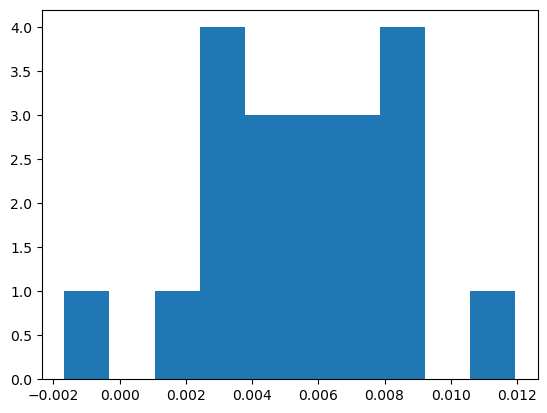

In [84]:
plt.hist(acc_test-0.5,bins=10)

In [77]:
mu = 0.5
test = pd.DataFrame(columns=['statics','p-value','H0'])

for clf in clf_names: 
    acc_test = accs_test_df.loc[clf]
    w_test = wilcoxon(acc_test-mu)
    if w_test.pvalue <= alpha_bonferroni:
        test.loc[clf]=[w_test.statistic,w_test.pvalue,False]
    else: 
        test.loc[clf]=[w_test.statistic,w_test.pvalue,True]

print(f'Significancia: {alpha_bonferroni:.2}')
print(f'Intervalo de confianza: {100*(1-alpha_bonferroni)}')
test

Significancia: 0.025
Intervalo de confianza: 97.5


,statics,p-value,H0
clf_1,649244.0,8.849670e-42,False
clf_2,734852.0,1.999913e-23,False
